In [1]:
# import packages
import zipfile
import urllib.request

import numpy as np
import sklearn.metrics
import sklearn.ensemble

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

from datasets import load_dataset

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

In [2]:
# download pre-trained GloVe vectors from the website
URL = 'https://nlp.stanford.edu/data/glove.6B.zip'
FILE_NAME = 'glove.6B.zip'
urllib.request.urlretrieve(URL, FILE_NAME)

with zipfile.ZipFile(FILE_NAME, 'r') as zip_ref:
    zip_ref.extractall()

# transfer pre-trained GloVe vectors into word2vec format
GLOVE_FILE = 'glove.6B.100d.txt'
WORD2VEC_FILE = GLOVE_FILE + '.word2vec'
glove2word2vec(GLOVE_FILE, WORD2VEC_FILE)

# load pre-trained GloVe vectors
glove_model = KeyedVectors.load_word2vec_format(WORD2VEC_FILE, binary=False)

/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_53242/779987310.py:12: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(GLOVE_FILE, WORD2VEC_FILE)


In [3]:
# load IMDB dataset
df = load_dataset('imdb')

train_text = df['train']['text']
train_label = df['train']['label']

test_text = df['test']['text']
test_label = df['test']['label']

Found cached dataset imdb (/Users/Jlonging/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# define functions for tokenizing the text data
class Word2VecVectorizer:
    def __init__(self, model_vec):
        print("Loading in word vectors...")
        self.word_vectors = model_vec
        print("Finished loading in word vectors")

    def fit(self, data):
        """fit data"""

    def transform(self, data):
        """determine the dimensionality of vectors"""
        v_get = self.word_vectors.get_vector('king')
        self.D = v_get.shape[0]

        x_vec = np.zeros((len(data), self.D))
        n_count = 0
        emptycount = 0

        for sentence in data:
            tokens = sentence.split()
            vecs = []
            m_count = 0
            for word in tokens:
                try:
                    # throws KeyError if word not found
                    vec = self.word_vectors.get_vector(word)
                    vecs.append(vec)
                    m_count += 1
                except KeyError:
                    pass

            if len(vecs) > 0:
                vecs = np.array(vecs)
                x_vec[n_count] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n_count += 1

        print("Numer of samples with no words found: %s / %s" % (emptycount,
        	len(data)))
        return x_vec

    def fit_transform(self, data):
        """transform the strings to vectors"""
        self.fit(data)

        return self.transform(data)

In [5]:
# set a word vectorizer
vectorizer = Word2VecVectorizer(glove_model)

# get the sentence embeddings for the train dataset
train_x = vectorizer.fit_transform(train_text)
train_y = train_label

# get the sentence embeddings for the test dataset
test_x = vectorizer.transform(test_text)
test_y = test_label

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 5 / 25000
Numer of samples with no words found: 4 / 25000


In [6]:
# train a Random Forest model
model = sklearn.ensemble.RandomForestClassifier(n_estimators=200)

model.fit(train_x, train_y)

RandomForestClassifier(n_estimators=200)

In [7]:
# accuracy report
print("model accuracy:", model.score(test_x, test_y))

predict_y = model.predict(test_x)

print(sklearn.metrics.classification_report(test_y, predict_y, digits=4))

model accuracy: 0.754
              precision    recall  f1-score   support

           0     0.7515    0.7590    0.7552     12500
           1     0.7566    0.7490    0.7528     12500

    accuracy                         0.7540     25000
   macro avg     0.7540    0.7540    0.7540     25000
weighted avg     0.7540    0.7540    0.7540     25000



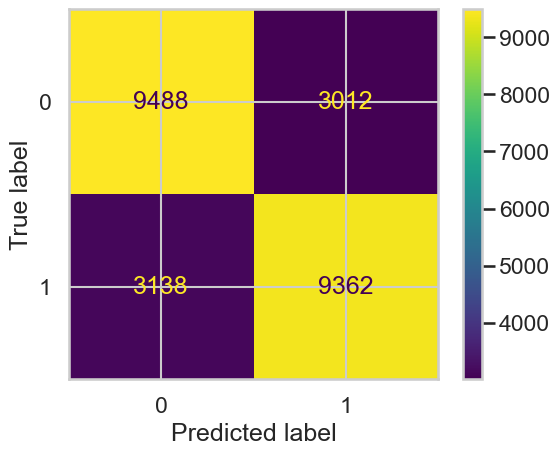

In [8]:
# plot a confusion matrix
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(model, test_x, test_y)